<a href="https://colab.research.google.com/github/bamel-yashvander/BrainTumorClassification/blob/master/BrainTumor_EfficientNetB1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Downloading the dataset

Upload the **kaggle.json** file to the session storage

In [ ]:
! pip install kaggle

! mkdir ~/.kaggle

! mv kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download sartajbhuvaji/brain-tumor-classification-mri/

In [ ]:
! mkdir data

! unzip -q brain-tumor-classification-mri.zip -d data/

Dataset can be found [**here**](https://www.kaggle.com/sartajbhuvaji/brain-tumor-classification-mri)

In [2]:
!nvidia-smi

Sat Jul 31 12:37:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Import Libraries

In [4]:
import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import imutils
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator, array_to_img
from tensorflow.keras.applications import EfficientNetB1

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Flatten, Dropout, Dense


### Create directories and paths to data

In [5]:
train_dir = './data/Training'
test_dir = './data/Testing/'


classes = os.listdir(train_dir) 
# classes = ['no_tumor', 'glioma_tumor', 'meningioma_tumor', 'pituitary_tumor']

os.mkdir('/content/Train-Data')
os.mkdir('/content/Test-Data')

for cls in classes:
  os.mkdir(f'/content/Train-Data/{cls}')
  os.mkdir(f'/content/Test-Data/{cls}')


In [6]:
classes

['meningioma_tumor', 'pituitary_tumor', 'no_tumor', 'glioma_tumor']

In [7]:
train_files_path = {cls: list(map(lambda x: os.path.join(train_dir, cls, x), os.listdir(os.path.join(train_dir, cls)))) for cls in classes}


### Visualize 5 random images from each class

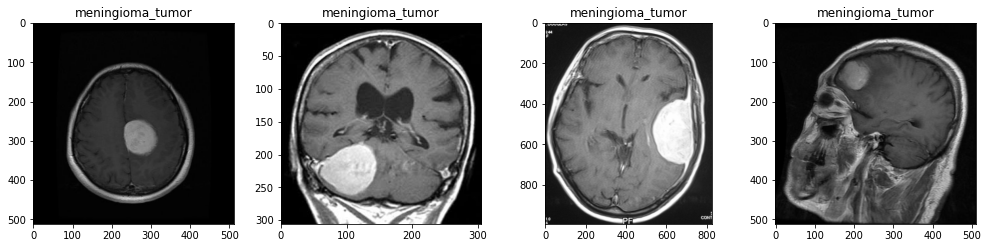

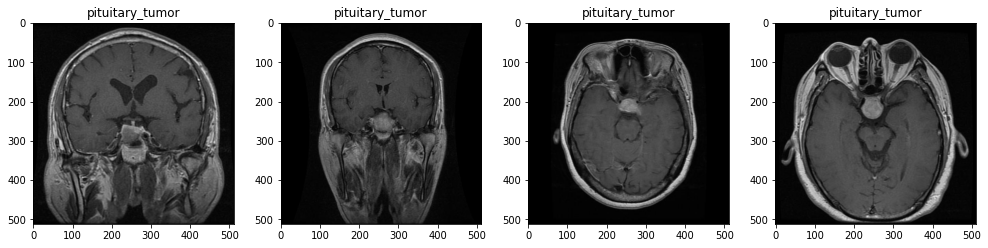

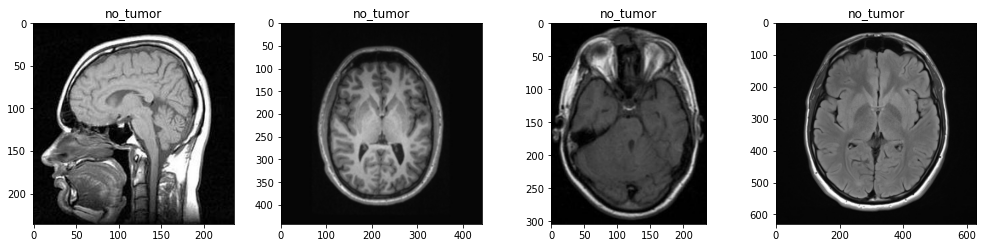

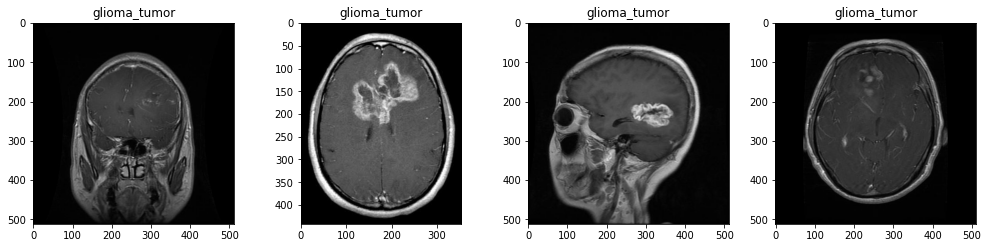

In [8]:
for cls in classes:
  plt.figure(figsize=(17, 17))
  random.shuffle(train_files_path[cls])
  files = train_files_path[cls][:5]

  for i in range(1, 5):
    plt.subplot(4, 4, i)
    plt.imshow(load_img(files[i]))
    plt.title(cls)


### Cropping and saving Images

In [9]:
def crop_image(image, plot=False):
    
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.GaussianBlur(img_gray, (5, 5), 0)
    
    img_thresh = cv2.threshold(img_gray, 45, 255, cv2.THRESH_BINARY)[1]
    img_thresh = cv2.erode(img_thresh, None, iterations=2)
    img_thresh = cv2.dilate(img_thresh, None, iterations=2)

    contours = cv2.findContours(img_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    c = max(contours, key=cv2.contourArea)

    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_image


In [10]:
# glioma = os.path.join(train_dir, 'glioma_tumor')
# meningioma = os.path.join(train_dir, 'meningioma_tumor')
# pituitary = os.path.join(train_dir, 'pituitary_tumor')
# no_tumor = os.path.join(train_dir, 'no_tumor')

### All above paths to train class directories in the following list
train_class_paths = [os.path.join(train_dir, cls) for cls in classes]

test_class_paths = [os.path.join(test_dir, cls) for cls in classes]


In [12]:
def crop_img_saver(class_read_paths, save_dir):
  save_root = '/content'

  for cls in class_read_paths:
    for i, p in tqdm(enumerate(os.listdir(cls))):
      path = os.path.join(cls, p)
      img = crop_image(cv2.imread(path), plot=False)

      if img is not None:
        img = cv2.resize(img, (224, 224))
        save_class = cls.split('/')[-1]
        save_path = os.path.join(save_root, save_dir, save_class, f'{str(i)}.jpg')
        cv2.imwrite(save_path, img)


In [13]:
crop_img_saver(train_class_paths, save_dir='Train-Data')

crop_img_saver(test_class_paths, save_dir='Test-Data')


937it [00:05, 177.00it/s]
901it [00:05, 154.61it/s]
501it [00:02, 240.13it/s]
926it [00:05, 171.25it/s]
5it [00:00, 158.68it/s]
5it [00:00, 121.54it/s]
5it [00:00, 331.78it/s]
5it [00:00, 183.66it/s]


### Data Augmentation and Preparation (Train, Validation and Test Sets)

In [14]:
train_data_generator = ImageDataGenerator(rotation_range=10, 
                                          height_shift_range=0.2, 
                                          horizontal_flip=True, 
                                          validation_split=0.2)

train_data = train_data_generator.flow_from_directory('/content/Train-Data/',
                                                      target_size=(224, 224),
                                                      batch_size=32,
                                                      class_mode='categorical',
                                                      subset='training')

validation_data = train_data_generator.flow_from_directory('/content/Train-Data',
                                                           target_size=(224, 224),
                                                           batch_size=32,
                                                           class_mode='categorical',
                                                           subset='validation')

test_data_generator = ImageDataGenerator()

test_data = test_data_generator.flow_from_directory('/content/Test-Data/',
                                        target_size=(224, 224),
                                        class_mode='categorical')


Found 2613 images belonging to 4 classes.
Found 652 images belonging to 4 classes.
Found 20 images belonging to 4 classes.


In [15]:
print(train_data.class_indices, test_data.class_indices, sep='\n')

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


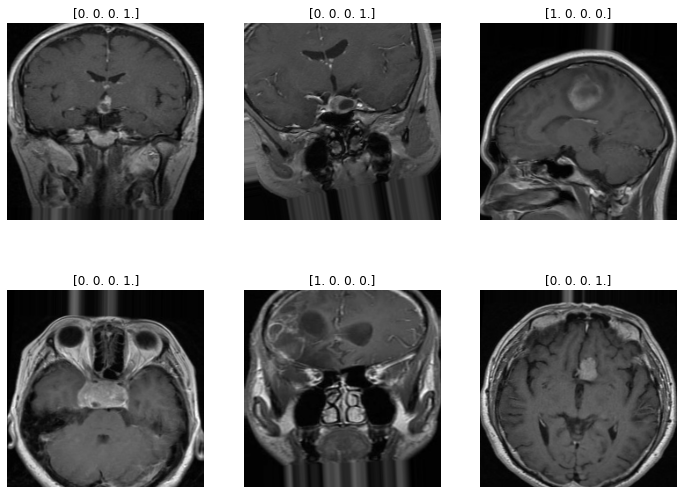

In [16]:
sample_x, sample_y = next(train_data)
plt.figure(figsize=(12, 9))
for i in range(6):
  plt.subplot(2, 3, i+1)
  plt.axis('off'), plt.grid(False)
  # sample_img = array_to_img(sample_x[i])
  plt.imshow(array_to_img(sample_x[i]))
  plt.title(sample_y[i])


### Creating and Compiling the model

In [17]:
effnet = EfficientNetB1(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model = effnet.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(4, activation='softmax')(model)
model = Model(inputs=effnet.input, outputs=model)

model.summary()

27025408/27018416 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_____________________________

In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  patience=5,
                                                  mode='auto',
                                                  verbose=1)

checkpoint = tf.keras.callbacks.ModelCheckpoint('model_ckpt.h5', 
                                                monitor='val_accuracy',
                                                save_best_only=True,
                                                mode='auto',
                                                verbose=1)

### Training and Evaluation

In [19]:
history = model.fit(train_data, 
                    epochs=10, 
                    validation_data=validation_data, 
                    callbacks=[checkpoint, early_stopping], 
                    verbose=1)


Epoch 1/10
82/82 [==============================] - 99s 680ms/step - loss: 0.8542 - accuracy: 0.6720 - val_loss: 0.8453 - val_accuracy: 0.6518

Epoch 00001: val_accuracy improved from -inf to 0.65184, saving model to model_ckpt.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
82/82 [==============================] - 51s 622ms/step - loss: 0.3924 - accuracy: 0.8649 - val_loss: 0.5072 - val_accuracy: 0.7914

Epoch 00002: val_accuracy improved from 0.65184 to 0.79141, saving model to model_ckpt.h5
Epoch 3/10
82/82 [==============================] - 50s 613ms/step - loss: 0.2413 - accuracy: 0.9147 - val_loss: 0.3240 - val_accuracy: 0.8896

Epoch 00003: val_accuracy improved from 0.79141 to 0.88957, saving model to model_ckpt.h5
Epoch 4/10
82/82 [==============================] - 51s 617ms/step - loss: 0.1749 - accuracy: 0.9372 - val_loss: 0.2315 - val_accuracy: 0.9187

Epoch 00004: val_accuracy improved from 0.88957 to 0.91871, saving model to model_ckpt.h5
Epoch 5/10
82/82 [==============================] - 51s 623ms/step - loss: 0.1193 - accuracy: 0.9610 - val_loss: 0.1626 - val_accuracy: 0.9417

Epoch 00005: val_accuracy improved from 0.91871 to 0.94172, saving model to model_ckpt.h5
Epoch 6/10
82/82 [==============================] - 51s 617ms/st

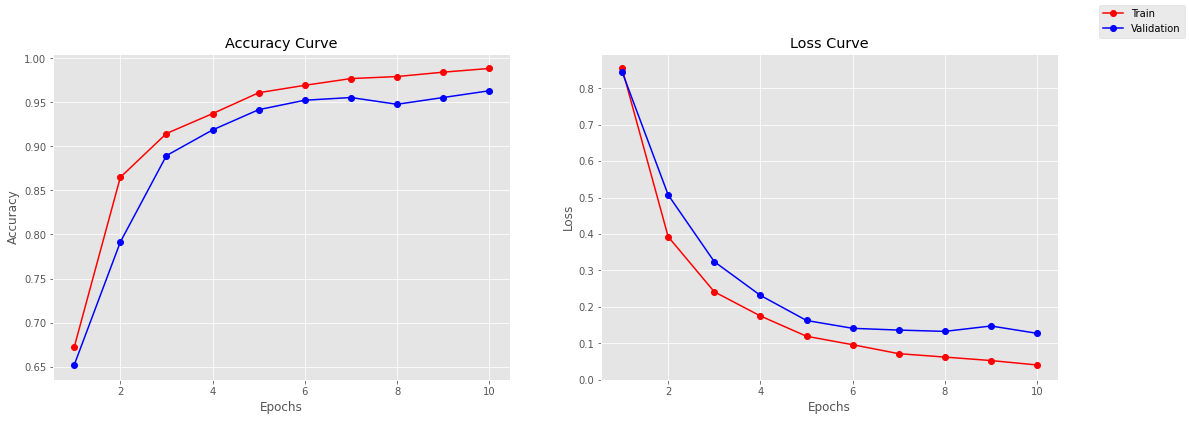

In [20]:
plt.style.use('ggplot')
figure = plt.figure(figsize=(18, 6))
epochs = range(1, 11)

plt.subplot(121)
plt.plot(epochs, history.history['accuracy'], 'ro-')
plt.plot(epochs, history.history['val_accuracy'], 'bo-')
plt.xlabel('Epochs'), plt.ylabel('Accuracy'), plt.title('Accuracy Curve')

plt.subplot(122)
plt.plot(epochs, history.history['loss'], 'ro-')
plt.plot(epochs, history.history['val_loss'], 'bo-')
plt.xlabel('Epochs'), plt.ylabel('Loss'), plt.title('Loss Curve')

figure.legend(['Train', 'Validation'])

In [21]:
model.evaluate(test_data)

1/1 [==============================] - 1s 775ms/step - loss: 0.0167 - accuracy: 1.0000


[0.01668098196387291, 1.0]

### Predicting class on test images

Model prediction probabilities: [[2.2407358e-04 2.3251199e-04 9.9949539e-01 4.8032471e-05]]
Output Class Label: 2
Predicted Class: no_tumor


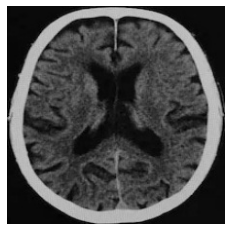

In [25]:
label_map = {v: k for k, v in test_data.class_indices.items()}

test_image = cv2.imread('/content/Test-Data/no_tumor/2.jpg')
plt.grid(0), plt.axis('off')
plt.imshow(test_image)
test_image = np.expand_dims(test_image, axis=0)

pred = model.predict(test_image)
print(f'Model prediction probabilities: {pred}')
pred = np.argmax(pred)
print(f'Output Class Label: {pred}')
pred = label_map[pred]
print(f'Predicted Class: {pred}')